# ***Head Pose***

Utilizaremos una red neuronal convolucional en Keras para detectar los ángulos de rotación de una cara.

Por ejemplo, enseñaremos a la red neuronal a detectar que en esta imagen aparece una cara rotada 60º y 75º en dos ejes:

<img src="data/Person05/person05102-60-75.jpg"></img>

Importación de las librerías necesarias

In [1]:
from sklearn.model_selection import train_test_split  
import re
import requests
import pandas as pd
import numpy as np
import glob
import os
import re
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend as K

In [2]:
# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
print('GPUs Available:', len(gpus))

GPUs Available: 1


Leemos las imágenes del directorio de trabajo y componemos un dataframe a partir de ellas

In [3]:
os.listdir('data')

['Front',
 'Person01',
 'Person02',
 'Person03',
 'Person04',
 'Person05',
 'Person06',
 'Person07',
 'Person08',
 'Person09',
 'Person10',
 'Person11',
 'Person12',
 'Person13',
 'Person14',
 'Person15',
 'README.txt']

In [4]:
DATA_PATH = 'data'
IMG_EXTENSION = 'jpg'
IMG_SIZE = 224
TXT_EXTENSION = 'txt'

# Procesar la imagen
def img_df(image_path, shape):
    image = Image.open(image_path)
    image_resized = image.resize(shape, Image.ANTIALIAS)
    img_array = np.asarray(image_resized)
    return img_array

# Dataframe a rellenar
colnames = ["X", "Y", "H", "W", "T", "P", "Image"]
df = pd.DataFrame(columns = colnames)

# finalmente deberíais tener algo como lo siguiente

df.X = df.X.astype(int)
df.Y = df.Y.astype(int)
df.H = df.H.astype(int)
df.W = df.W.astype(int)
df = df.reset_index().drop("index", axis=1)

all_paths = os.listdir(DATA_PATH)
regex = re.compile('^Person\d+$')
paths = list(filter(regex.match, all_paths))

# Cargamos las imagenes una a una
for path in paths:
    wd = os.path.join(DATA_PATH, path)
    all_files = os.listdir(wd)
    persons = list(set([re.sub(r'\.[a-z|A-Z]{3}$', '', file) for file in all_files]))
    
    for person in persons:
        t = int(re.sub(r'(^person\d+|(\+|-)\d+$)', '', person))
        p = int(re.sub(r'(^person\d+(\+|-)\d+)', '', person))
        
        image_file = os.path.join(wd, person + '.' + IMG_EXTENSION)
        text_file = os.path.join(wd, person + '.' + TXT_EXTENSION)
        
        img = img_df(image_file, (IMG_SIZE, IMG_SIZE))
        txt = pd.read_csv(text_file, skiprows = 3, header=None).to_numpy()
        
        txt = np.squeeze(txt, axis = 1)
        
        df = df.append({'X': txt[0], 'Y': txt[1], 'H': txt[2], 'W': txt[3], 'T': t, 'P': p, 'Image': img}, ignore_index=True)
        
df

,X,Y,H,W,T,P,Image
0,260,133,74,117,0,-75,"[[[22, 22, 22], [16, 16, 16], [56, 56, 56], [1..."
1,266,155,108,123,-15,-45,"[[[21, 21, 21], [15, 15, 15], [57, 57, 57], [1..."
2,107,144,91,110,0,90,"[[[22, 22, 22], [15, 15, 15], [55, 55, 55], [1..."
3,202,96,112,94,60,-15,"[[[21, 21, 21], [15, 15, 15], [55, 55, 55], [1..."
4,177,95,118,100,60,15,"[[[20, 22, 21], [14, 16, 15], [55, 57, 56], [1..."
...,...,...,...,...,...,...,...
2785,92,163,83,105,0,60,"[[[22, 21, 19], [17, 15, 13], [52, 52, 50], [1..."
2786,72,132,80,113,30,75,"[[[21, 21, 21], [14, 14, 14], [48, 48, 48], [1..."
2787,104,133,90,102,30,45,"[[[21, 20, 18], [18, 17, 15], [52, 51, 49], [1..."
2788,199,188,113,106,-30,-30,"[[[21, 21, 21], [16, 16, 16], [51, 51, 51], [1..."


In [5]:
# Dividimos en input y output
X = np.array(list(df['Image'].values)).astype(int)
Y = np.array(list(df[['T', 'P']].values)).astype(int)

In [6]:
# Dividimos en conjunto de prueba y validación
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=3245790)

Aplicando transfer learning, importamos la red MobileNet y descongelamos las últimas capas

In [7]:
from keras.applications import MobileNet
from tensorflow.keras import layers
import keras

model = MobileNet(include_top=False)
print("%i capas" % len(model.layers))
model.summary()

86 capas
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, Non

In [8]:
# Construimos un modelo basado en MobileNet

def create_model():
    base_model = MobileNet(
        input_shape=None,
        alpha=1.0,
        depth_multiplier=1,
        dropout=0.001,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classifier_activation="softmax"
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(100,activation='relu')(x)
    x = keras.layers.Dense(100,activation='relu')(x)
    x = keras.layers.Dense(50,activation='relu')(x)

    outputs = keras.layers.Dense(2, activation='linear')(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mean_squared_error", 'cosine_similarity'])
    
    return model

Entrenamos

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [10]:
from keras.callbacks import EarlyStopping

with strategy.scope():
    model = create_model()
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, restore_best_weights=True, patience=5)

MAX_EPOCHS = 35
BATCH_SIZE = 32

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102   

In [12]:
hist = model.fit(
    X_train, Y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, Y_test),
    verbose=2,
    callbacks=[es]
)

Epoch 1/35
70/70 - 17s - loss: 2142.0718 - mean_squared_error: 2142.0718 - cosine_similarity: 0.3370 - val_loss: 1735.8793 - val_mean_squared_error: 1735.8793 - val_cosine_similarity: 0.6082
Epoch 2/35
70/70 - 4s - loss: 1263.5128 - mean_squared_error: 1263.5128 - cosine_similarity: 0.6448 - val_loss: 829.5525 - val_mean_squared_error: 829.5525 - val_cosine_similarity: 0.7909
Epoch 3/35
70/70 - 4s - loss: 703.8393 - mean_squared_error: 703.8393 - cosine_similarity: 0.8021 - val_loss: 622.6615 - val_mean_squared_error: 622.6615 - val_cosine_similarity: 0.8227
Epoch 4/35
70/70 - 4s - loss: 546.7610 - mean_squared_error: 546.7610 - cosine_similarity: 0.8384 - val_loss: 523.0228 - val_mean_squared_error: 523.0228 - val_cosine_similarity: 0.8576
Epoch 5/35
70/70 - 4s - loss: 442.7782 - mean_squared_error: 442.7782 - cosine_similarity: 0.8643 - val_loss: 499.5476 - val_mean_squared_error: 499.5476 - val_cosine_similarity: 0.8479
Epoch 6/35
70/70 - 4s - loss: 394.6520 - mean_squared_error: 39

In [13]:
Y_pred = model(X_test)
np.transpose(Y_test)

array([[-15, -30,   0, ...,  15, -15,   0],
       [  0, -15,  75, ..., -90,  60,  30]])

Dibujamos la correlación entre el ángulo que hemos estimado y el real

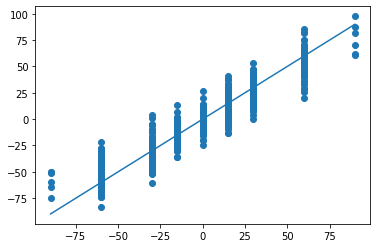

In [14]:
plt.clf()
plt.scatter(x = np.transpose(Y_test)[0], y = np.transpose(Y_pred)[0], )
plt.plot([-90, 90], [-90, 90])

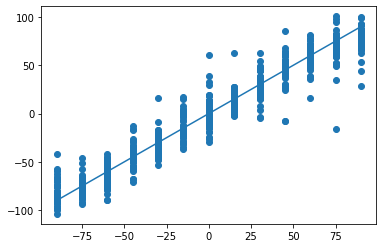

In [15]:
plt.clf()
plt.scatter(x = np.transpose(Y_test)[1], y = np.transpose(Y_pred)[1])
plt.plot([-90, 90], [-90, 90])

In [16]:
model.save('modelo1.h5')